In [1]:
import os
import pandas as pd
import glob
from typing import List, Optional
import matplotlib.pyplot as plt

In [2]:
def get_patch_switch_idx(folder_path):
    """
    Returns:
    - List[List[int]]: A list where each element is a list of row idx for a file.
    """
    result = []
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    csv_files.sort()
    
    for file_path in csv_files:
        try:
            df = pd.read_csv(file_path)
            
            if 'associative_patch_switch' not in df.columns:
                print(f"Warning: 'associative_patch_switch' column not found in {file_path}. Skipping this file.")
                result.append([])  # Append empty list for this file
                continue
            
            switch_idx = df.index[df['associative_patch_switch'] == 1.0].tolist()
            switch_idx = [idx + 1 for idx in switch_idx]
            result.append(switch_idx)
        
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            result.append([])  # Append empty list in case of error
    
    return result

In [3]:
folder = "results/random_walks_human"
lists_of_idx = get_patch_switch_idx(folder)
for i, idx in enumerate(lists_of_idx, 1):
    print(f"File {i}: {idx}")

File 1: [1, 3, 7, 16, 17, 21, 22, 23, 27, 29, 30, 43, 44, 46, 48, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61]
File 2: [1, 5, 6, 7, 8, 9, 10, 13, 15, 16, 27, 28, 33, 39, 49, 57, 58, 63, 64, 65, 67, 68]
File 3: [1, 4, 7, 9, 11, 16, 21, 26, 29, 30, 31, 33, 35, 40, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54]
File 4: [1, 2, 3, 5, 9, 11, 14, 15, 17, 20, 24, 25, 26, 27, 30, 31, 34, 35, 36, 37, 38, 40, 43, 44, 46, 47, 48, 52, 53, 54]
File 5: [1, 3, 4, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 20, 23, 24, 25, 27, 32, 33, 34, 37, 38, 42, 44, 48, 49]


In [4]:
def move_idx(list_of_lists: List[List[int]], move_pos: int) -> List[List[int]]:
    """
    Parameters:
    - list_of_lists (List[List[int]]): The input list of lists containing integers.
    - move_pos (int): The integer value to add to each element.

    Returns:
    - List[List[int]]: A new list of lists with adjusted and filtered elements.
    """
    if not isinstance(list_of_lists, list):
        raise ValueError("Input must be a list of lists.")
    
    moved_lists = []
    for sublist_index, sublist in enumerate(list_of_lists):
        if not isinstance(sublist, list):
            raise ValueError(f"Element at index {sublist_index} is not a list.")
        
        adjusted_sublist = []
        for elem_index, elem in enumerate(sublist):
            if not isinstance(elem, int):
                raise ValueError(f"Element at sublist {sublist_index}, index {elem_index} is not an integer.")
            adjusted_value = elem + move_pos
            if adjusted_value > 0:
                adjusted_sublist.append(adjusted_value)
            # If the adjusted value is negative, it is excluded
        
        moved_lists.append(adjusted_sublist)
    
    return moved_lists

In [5]:
moved_idx = move_idx(lists_of_idx, -2)
for i, idx in enumerate(moved_idx, 1):
    print(f"File {i}: {idx}")

File 1: [1, 5, 14, 15, 19, 20, 21, 25, 27, 28, 41, 42, 44, 46, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59]
File 2: [3, 4, 5, 6, 7, 8, 11, 13, 14, 25, 26, 31, 37, 47, 55, 56, 61, 62, 63, 65, 66]
File 3: [2, 5, 7, 9, 14, 19, 24, 27, 28, 29, 31, 33, 38, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52]
File 4: [1, 3, 7, 9, 12, 13, 15, 18, 22, 23, 24, 25, 28, 29, 32, 33, 34, 35, 36, 38, 41, 42, 44, 45, 46, 50, 51, 52]
File 5: [1, 2, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 18, 21, 22, 23, 25, 30, 31, 32, 35, 36, 40, 42, 46, 47]


In [6]:
def get_average_irt(folder_path: str, move_pos: Optional[int] = None) -> Optional[float]:
    """
    Computes average IRT across CSV files in a folder based on specified conditions.

    - If move_pos is None:
        Computes average IRT across all valid (non-blank) rows in all CSV files
    - If move_pos is provided:
        Computes average IRT at rows where 'associative_patch_switch' == 1, adjusted by move_pos
    """
    if not os.path.isdir(folder_path):
        raise ValueError(f"The folder path '{folder_path}' does not exist or is not a directory.")
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    csv_files.sort()
    if not csv_files:
        print(f"No CSV files found in the folder '{folder_path}'.")
        return None
    
    if move_pos is None:
        # Compute average IRT across all valid (non-blank) rows in all CSV files
        total_irt = 0.0
        count = 0

        for file_path in csv_files:
            try:
                df = pd.read_csv(file_path)
                if 'irt' not in df.columns:
                    raise ValueError(f"IRT column not found in {file_path}")
                # Convert 'irt' to numeric, coercing errors to NaN, then drop NaN values
                irt_values = pd.to_numeric(df['irt'], errors='coerce').dropna()
                valid_irt = irt_values.tolist()
                if not valid_irt:
                    print(f"Warning: No valid 'irt' values found in {file_path}.")
                    continue
                total_irt += sum(valid_irt)
                count += len(valid_irt)
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")
                continue
        
        if count == 0:
            print("No valid 'irt' values found across all files")
            return None
        average_irt = total_irt / count
        return average_irt
    
    else:
        # Compute average IRT at rows where 'associative_patch_switch' == 1, adjusted by move_pos
        switch_idx_list = get_patch_switch_idx(folder_path)
        adjusted_switch_idx_list = move_idx(switch_idx_list, move_pos)
        collected_irt = []
        
        for file_path, adjusted_switch_idx in zip(csv_files, adjusted_switch_idx_list):
            try:
                df = pd.read_csv(file_path)
                num_rows = len(df)
                
                if 'irt' not in df.columns:
                    raise ValueError(f"IRT column not found in {file_path}")
                if not adjusted_switch_idx:
                    raise ValueError(f"No valid adjusted switch idx in {file_path} after applying move_pos={move_pos}")
                
                adjusted_switch_idx = [idx for idx in adjusted_switch_idx if 1 <= idx <= num_rows]
                
                if not adjusted_switch_idx:
                    print(f"Info: No valid adjusted idx within range in {file_path}.")
                    continue
                
                adjusted_switch_idx_zero_based = [idx - 1 for idx in adjusted_switch_idx]
                irt_values = df.loc[adjusted_switch_idx_zero_based, 'irt']
                irt_values = pd.to_numeric(irt_values, errors='coerce').dropna()
                valid_irt = irt_values.tolist()
                
                if not valid_irt:
                    print(f"Info: No valid 'irt' values at adjusted idx in {file_path}.")
                    continue
                
                collected_irt.extend(valid_irt)
            
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")
                continue
        
        if not collected_irt:
            print("No valid 'irt' values found based on the specified conditions.")
            return None
        
        average_irt = sum(collected_irt) / len(collected_irt)
        return average_irt

In [7]:
print(get_average_irt('results/random_walks_human', 0))

3.56484375


In [8]:
def plot_irt(folder_path: str):
    overall_average_irt = get_average_irt(folder_path)
    average_irt_ratio = []
    for move_pos in range(-3, 4):
        average_irt = get_average_irt(folder_path, move_pos)
        average_irt_ratio.append(average_irt / overall_average_irt)
    
    plt.figure(figsize=(8, 6))
    plt.bar(range(-3, 4), average_irt_ratio)
    plt.xlabel('Patch Entry Position', fontsize=16)
    plt.ylabel('Ratio of IRT over Subjects\' Mean IRT', fontsize=16)
    plt.axhline(y=1, color='r', linestyle='--')
    plt.xticks(range(-3, 4), ['-3', '-2', '-1', '1', '2', '3', '4'], fontsize=12)
    plt.yticks(fontsize=12)

    if 'category' in folder_path:
        label = 'category'
    elif 'llm' in folder_path:
        label = 'llm'
    elif 'human' in folder_path:
        label = 'human'
    plt.savefig(f'results/irt/{label}_irt.png')

    plt.show()

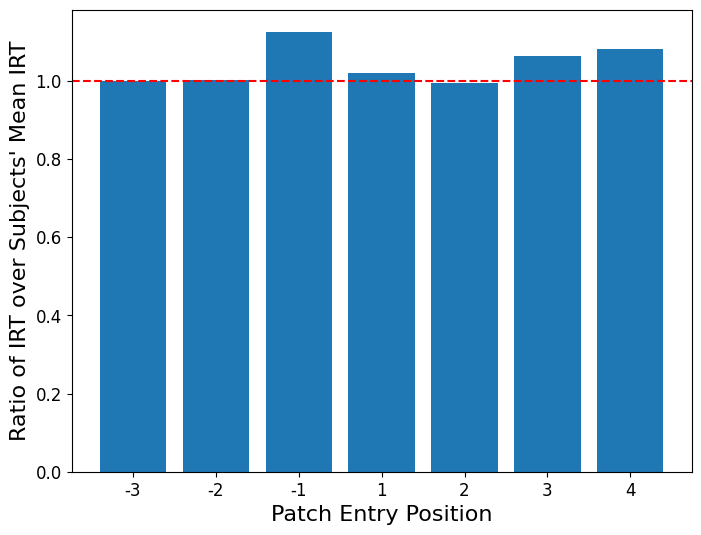

<Figure size 640x480 with 0 Axes>

In [9]:
plot_irt('results/random_walks_category')

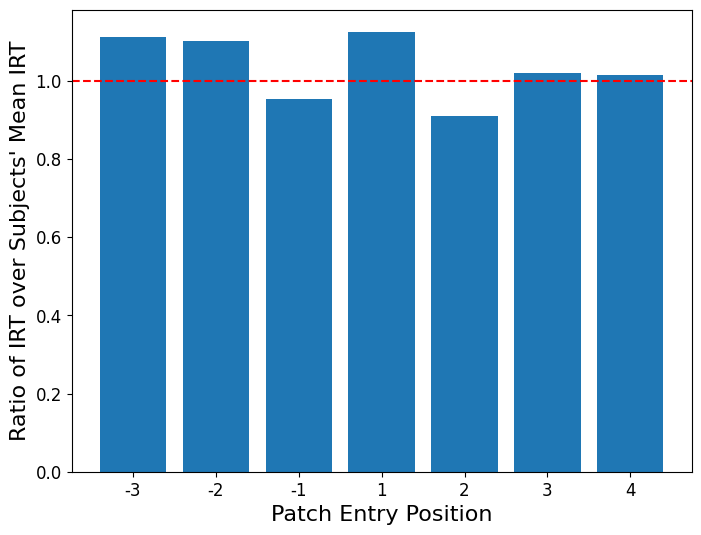

<Figure size 640x480 with 0 Axes>

In [10]:
plot_irt('results/random_walks_llm')

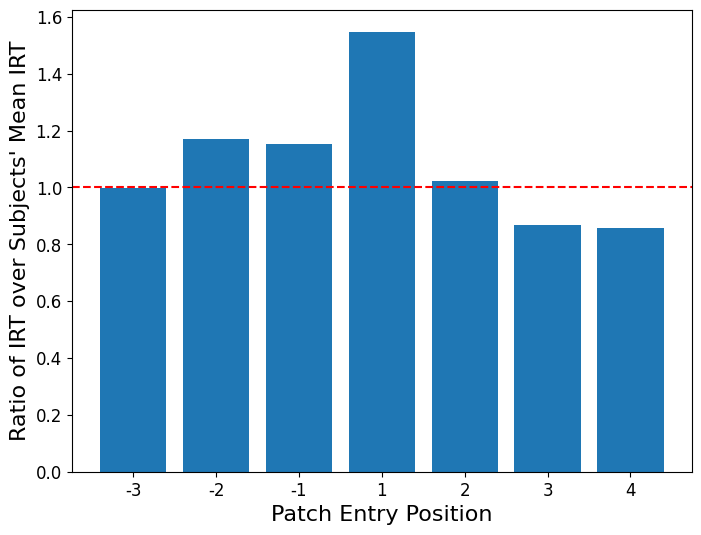

<Figure size 640x480 with 0 Axes>

In [11]:
plot_irt('results/random_walks_human')